# Modeling Energy Levels with Neural Networks

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes.

This notebook uses the ENSDF Dataset and builds a model to predict the level energy of several isotopes. To do this, we'll provide the model with a description of many expeirmentally measrued values and accepted values. This description includes attributes like: # of neutrons, # of protons, and Atomic Mass.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from  IPython import display
import pathlib
import shutil
import tempfile
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
sns.set_style("darkgrid")

2.0.0


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12525380436705854962, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6614766059
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11766756432482258680
 physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:42:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6618563871
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10318697669301106391
 physical_device_desc: "device: 1, name: GeForce RTX 2060 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"]

# Getting the Data: Cross Sections

In [5]:
print("Reading data into dataframe...")
df = pd.read_csv("./ENSDF/ensdf_v2.csv")
print("Data read into dataframe!")

# Converting specific columns to datatype 'string'
str_cols = ["Spin", "Parity", "Element_w_A"]
df[str_cols] = df[str_cols].astype('category')

# Converting remaining columns to numeric type. 
for col in list(df.columns):
    if col not in str_cols:
        df[col] = df[col].astype(float)

# Converting proton, neutron and mass number features to integers
int_cols = ["Level_Number", "Protons", "Target_Neutrons"]
df[int_cols] = df[int_cols].astype(int)

Reading data into dataframe...
Data read into dataframe!


In [6]:
df.columns

Index(['Level_Number', 'Level_Energy', 'Spin', 'Parity', 'Element_w_A',
       'Protons', 'Target_Neutrons', 'Atomic_Mass_Micro'],
      dtype='object')

In [7]:
df.shape

(21355, 8)

In [8]:
basic_cols = ["Level_Number", "Level_Energy", "Protons", "Target_Neutrons", "Atomic_Mass_Micro", "Element_w_A"]
df = df[basic_cols]

# Known Upper Levels 

In [103]:
print("Reading data into dataframe...")
df2 = pd.read_csv("./ENSDF/ensdf_v1.csv")
print("Data read into dataframe!")

# Converting specific columns to datatype 'string'
str_cols = ["Spin", "Parity", "Element_w_A", "Element"]
df2[str_cols] = df2[str_cols].astype('category')

# Converting remaining columns to numeric type. 
for col in list(df.columns):
    if col not in str_cols:
        df2[col] = df2[col].astype(float)

# Converting proton, neutron and mass number features to integers
int_cols = ["Level_Number", "Protons", "Target_Neutrons", "Target_Mass_Number"]
df2[int_cols] = df2[int_cols].astype(int)

Reading data into dataframe...
Data read into dataframe!


# One-Hot-Encoding of Categorical Data 

Categorical data can be represented by either assigning a numerical value to each category or by a sparse binary matrix where a `1` is placed when the category is present. We opted for the latter. In this case the categorical features include:

> `MT`: which refers to the ENDF reaction number. 

> `spin`: 

> `parity`

In [17]:
# # Specify categorical variables calculating one-hot-encode features 
# # The useful categorical feature can also be Out, in this case we use OUT
# cat_cols = ["MT", "spin", "parity"]
# df = pd.concat([df, pd.get_dummies(df[cat_cols])], axis=1).drop(columns=cat_cols)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021095C60A08>,
      dtype=object)

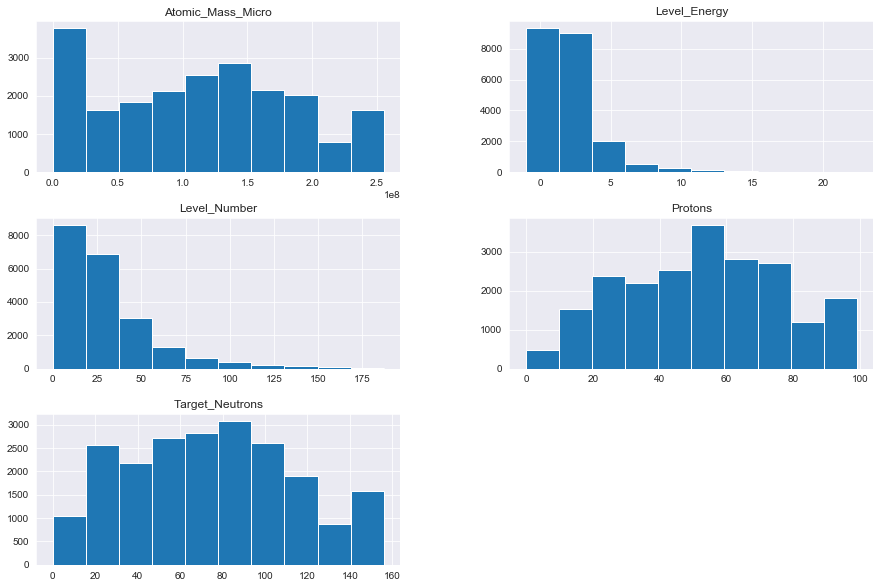

In [9]:
df.hist(figsize=(15,10))

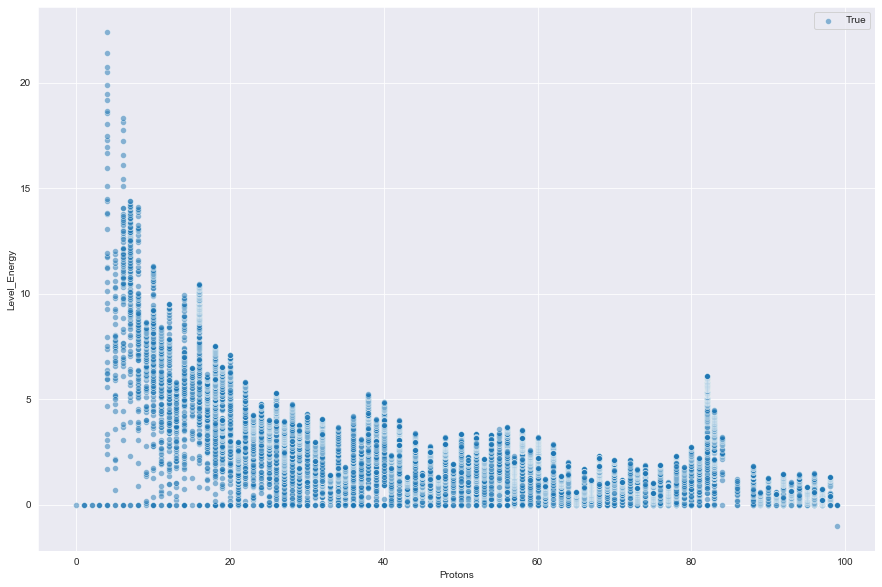

In [10]:
plt.figure(figsize=(15,10))
sns.scatterplot(df["Protons"], df["Level_Energy"], alpha=0.5, label="True")

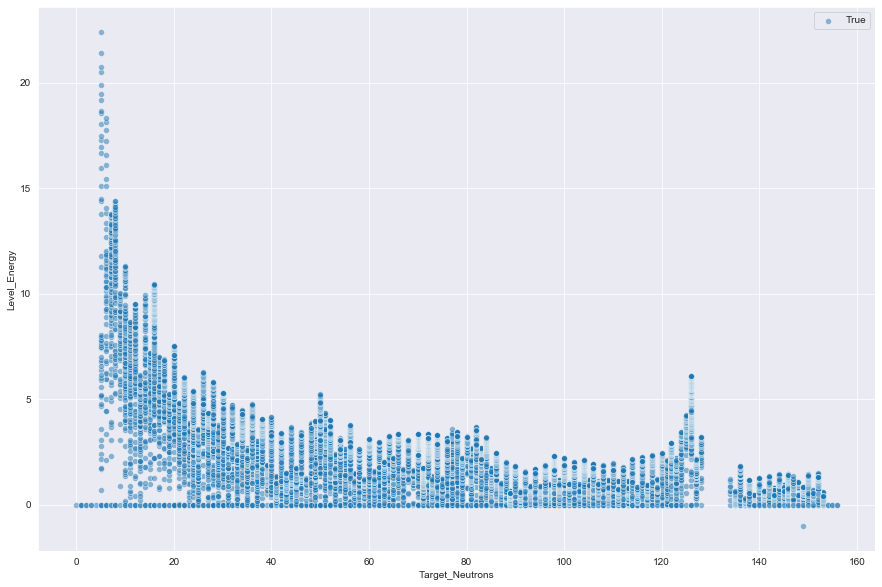

In [11]:
plt.figure(figsize=(15,10))
sns.scatterplot(df["Target_Neutrons"], df["Level_Energy"], alpha=0.5, label="True")

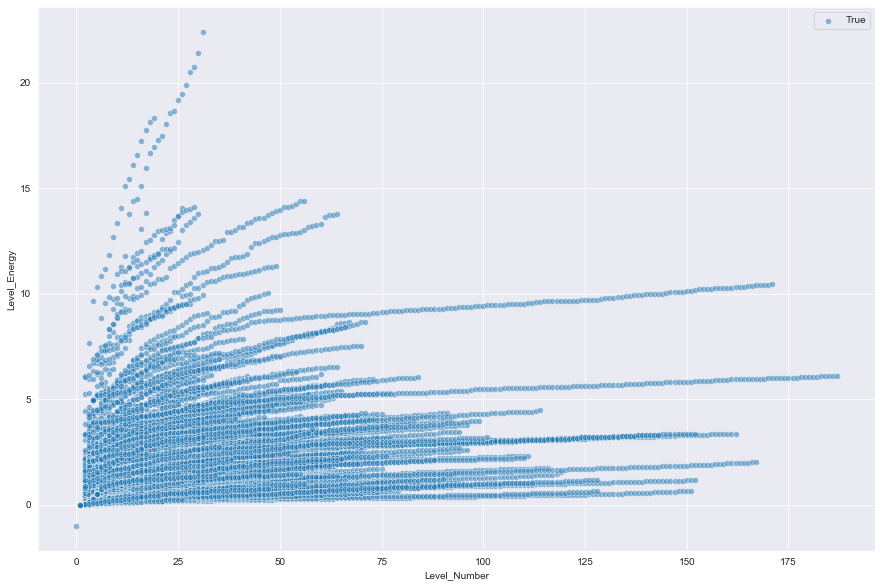

In [12]:
plt.figure(figsize=(15,10))
sns.scatterplot(df["Level_Number"], df["Level_Energy"], alpha=0.5, label="True")

In [13]:
def plot_levels_axh(protons, neutrons):
    to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(10,15))
    for i in to_plot["Level_Energy"].values:
        plt.axhline(i, c="r", alpha=0.5)
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Energy (MeV)')
    
def plot_levels_sctr(protons, neutrons):
    to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(15,10))
    sns.scatterplot(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.5, label="True")
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Energy (MeV)')
    
def plot_levels_density(protons, neutrons, binning):
    to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(15,10))
        
    count, division = np.histogram(to_plot.Level_Energy, bins=binning)
    to_plot.Level_Energy.hist(bins=division)

    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.xlabel('Energy (MeV)')
    
binning = []
binning.extend(np.arange(0,14,0.1))

In [16]:
binning = []
binning.extend(np.arange(0,14,0.05))

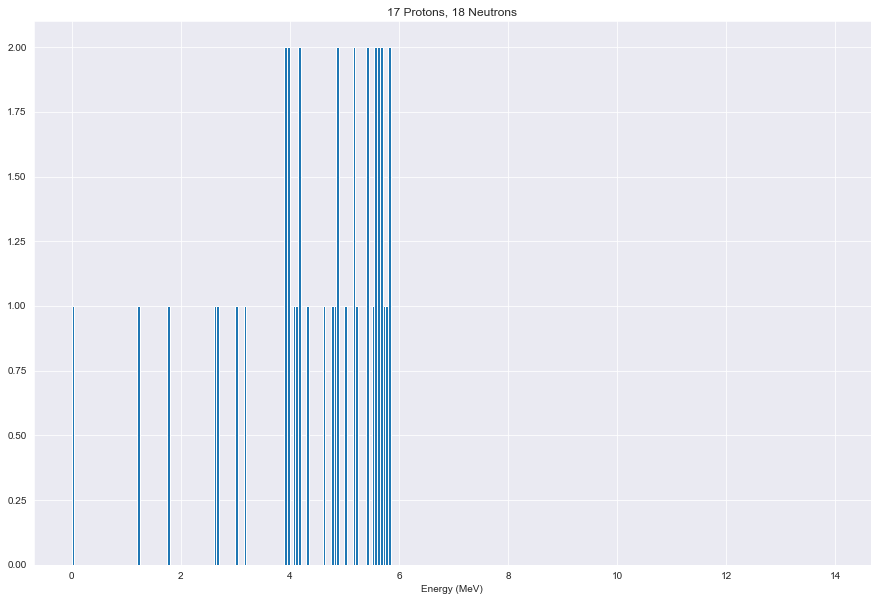

In [17]:
plot_levels_density(17, 35-17, binning)

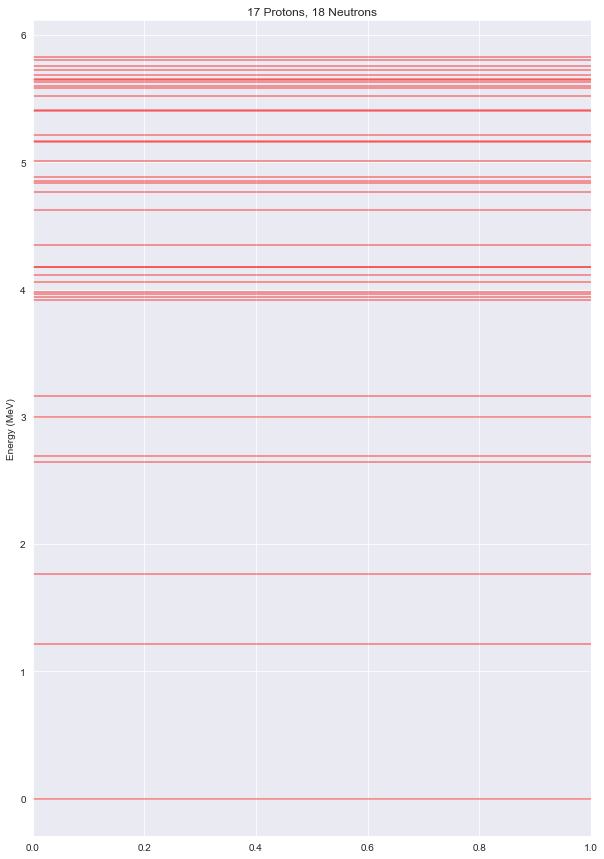

In [18]:
plot_levels_axh(17, 35-17)

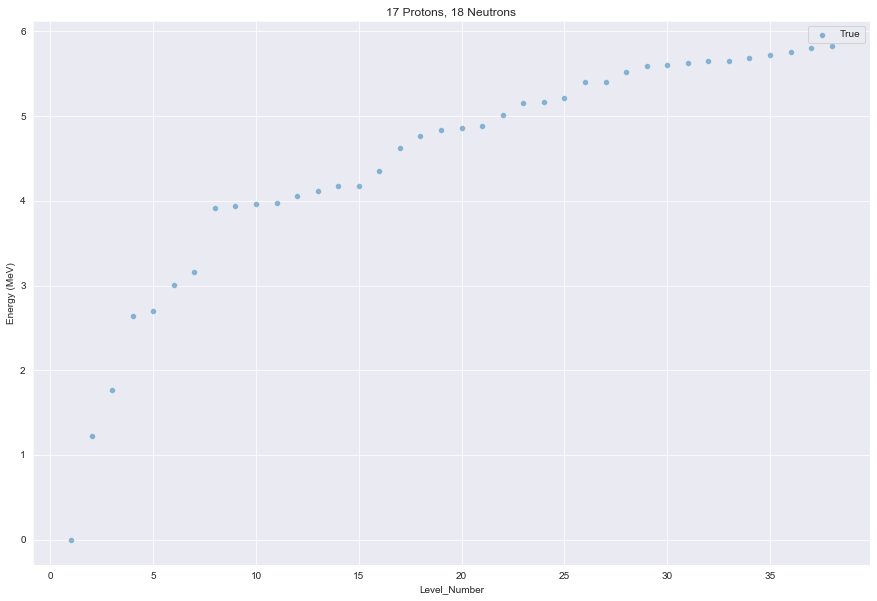

In [20]:
plot_levels_sctr(17, 35-17)

# Evaluating Predictions

Two very important measures that are often used in Statistics to determine the accuracy of a model are:

> **R^2 / R-squared**:  also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line. The value of the R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.

> **Mean Squared Error (MSE)**: measures the average of the squares of errors, that is, the difference between actual value (y) and the estimated value (Å·).
 

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

# Creating Training, Validation, and Testing Datasets

In [22]:
from sklearn.model_selection import train_test_split

In [26]:
train_size = 0.8
test_size = 1 - 0.8
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["Level_Energy", "Element_w_A"], axis=1), df["Level_Energy"], test_size=0.20)

# Data Standarization 

For DT, normalization does not matter generally. However, for other algorithms like simple/multiple linear regression, neural networks, and k-clustering magnitudes of different features can create unexpected biases towards features with larger magnitudes.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [27]:
from sklearn import preprocessing

In [29]:
# Specify columns to scale
to_scale = list(x_train.columns)
scaler = preprocessing.StandardScaler().fit(x_train[to_scale])

In [30]:
x_train[to_scale] = scaler.transform(x_train[to_scale])
x_test[to_scale] = scaler.transform(x_test[to_scale])

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

# Prediction and Plotting Function

The following functions will be used to easily use the traine model to visualize the results on a particular isotope with a specific reaction type. 

In [31]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    ''' Flexibly plot a univariate distribution of observations. '''
    plt.figure(figsize=(12, 10))
    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(Title)
    plt.xlabel('Level Energy (MeV)')
    plt.ylabel('Proportion of Data')
    plt.show()

In [ ]:
def plot_levels_axh(protons, neutrons, df, save=False):
    to_plot = df[(df["Protons"] == protons) & (df["Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(10,15))
    for i in to_plot["Level_Energy"].values:
        plt.axhline(i, c="r", alpha=0.7)
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Energy (MeV)')
    plt.xticks([], [])
    if save == True:
        plt.savefig(figure_dir + 'ENSDF_{}_AXH_Level_Density.png'.format(to_plot.Element_w_A.iloc[0]), bbox_inches='tight')
    
def plot_levels_sctr(protons, neutrons, df):
    to_plot = df[(df["Protons"] == protons) & (df["Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(15,10))
    sns.scatterplot(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.5, label="True")
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Energy (MeV)')
    
def plot_levels_density(protons, neutrons, binning, df):
    to_plot = df[(df["Protons"] == protons) & (df["Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(15,10))
        
    count, division = np.histogram(to_plot.Level_Energy, bins=binning)
    to_plot.Level_Energy.hist(bins=division)

    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.xlabel('Energy (MeV)')
binning = []
binning.extend(np.arange(0,14,0.2))

def plot_level_density(protons, neutrons, df, df2=pd.DataFrame(), save=False):
    to_plot = df[(df["Protons"] == protons) & (df["Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True)
    plt.figure(figsize=(15,10))
    to_plot["N"] = np.cumsum(to_plot.Level_Number)
    plt.plot(to_plot.Level_Energy, to_plot.N, c='blue', label="Adopted")
    if df2.shape[0] != 0:
        to_plot_2 = df2[(df2["Protons"] == protons) & (df2["Neutrons"] == neutrons)].sort_values(
            by='Level_Number', ascending=True)
        to_plot_2["N"] = np.cumsum(to_plot_2.Level_Number)
        plt.plot(to_plot_2.Level_Energy, to_plot_2.N, c='green', label="Cut-Off")
    plt.yscale('log')
    plt.title("Level Density for {}: {} Protons, {} Neutrons".format(to_plot.Element_w_A.iloc[0] ,protons, neutrons))
    plt.ylabel("N (Number of Levels)")
    plt.legend()
    plt.xlabel("Energy (MeV)")
    if save == True:
        plt.savefig(figure_dir + 'ENSDF_{}_Level_Density.png'.format(to_plot.Element_w_A.iloc[0]), bbox_inches='tight')

In [227]:
def predicting_nuclear_xs(protons, neutrons, clf, N=0, adopted=False, tf_dataset=False):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, N).
    '''
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True).drop(columns="Element_w_A")
    to_infer = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True).drop(columns=["Level_Energy", "Element_w_A"])
    
    if N != 0:
        last_level = to_plot.Level_Number.iloc[-1]
        level_range = np.arange(last_level, last_level + N , 1)
        to_infer2 = pd.DataFrame({"Level_Number": level_range})
        for i in list(to_infer.columns)[1:]:
                to_infer2[i] = to_infer[i].values[1]
        to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Level_Number', ascending=True)

    if adopted == True:
        to_plot_2 = df2[(df2["Protons"] == protons) & (df2["Target_Neutrons"] == neutrons) & (df2["Level_Number"] >= last_level)].sort_values(
            by='Level_Number', ascending=True).drop(
            columns=["Element_w_A", "Spin", "Parity", "Target_Mass_Number", "Element"])
    
    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])
        
    infer_dataset = tf.data.Dataset.from_tensor_slices(
        (to_infer.values)).batch(len(to_infer))
    y_hat  = clf.predict(infer_dataset)

    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
        
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    true = plt.scatter(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.3, c='b')
    if adopted == True:
        adopted_plot = plt.scatter(to_plot_2["Level_Number"], to_plot_2["Level_Energy"], alpha=0.3, c='g')
    pred = plt.scatter(to_infer["Level_Number"], y_hat.flatten(), alpha=0.5, label="Pred", c="orange")
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Level Energy (MeV)')
    plt.xlabel('Level Number')
    plt.legend((true, pred), ('ENSDF', "NN ENSDF Pred"), loc='upper left')    
    all_y = np.concatenate((to_plot["Level_Energy"], y_hat.flatten()))
    minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
    maximum_y = all_y.max() + all_y.max() * 0.05
    plt.ylim(minimum_y, maximum_y)
    plt.show()
    
    if N != 0:
        print("XS Tree vs EXFOR:")
        print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()[:last_level]))
        print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()[:last_level]))
    else:
        print("XS Tree vs EXFOR:")
        print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()))
        print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()))    

    if (N != 0 and adopted == True):
        print("hello")
        plt.figure(figsize=(16,10))     
        count, division = np.histogram(to_plot.Level_Energy, bins=binning)
        kwargs = dict(ec="k", histtype='stepfilled', alpha=0.5, bins=division)
        histogram_og = pd.DataFrame(to_plot.Level_Energy.values, columns=["Level_Energy"])
        histogram_og.Level_Energy.hist(color="green", label="Cut-Off", **kwargs)
        histogram_new = pd.DataFrame(y_hat.flatten(), columns=["Level_Energy"])
        histogram_new.Level_Energy.hist(color="lightblue", label="Predictions", **kwargs)
        histogram_ad = pd.DataFrame(to_plot_2.Level_Energy.values, columns=["Level_Energy"])
        histogram_ad.Level_Energy.hist(color="salmon", label="Adopted", **kwargs)
        plt.legend()
        plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
        plt.xlabel('Energy (MeV)')
        plt.yscale('log')
    elif (N != 0 and adopted == False):
        print('hello2')
        plt.figure(figsize=(16,10))     
        count, division = np.histogram(to_plot.Level_Energy, bins=binning)
        kwargs = dict(ec="k", histtype='stepfilled', alpha=0.5, bins=division)
        histogram_og = pd.DataFrame(to_plot.Level_Energy.values, columns=["Level_Energy"])
        histogram_og.Level_Energy.hist(color="green", label="Cut-Off", **kwargs)
        histogram_new = pd.DataFrame(y_hat.flatten(), columns=["Level_Energy"])
        histogram_new.Level_Energy.hist(color="lightblue", label="Predictions", **kwargs)
        plt.legend()
        plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
        plt.xlabel('Energy (MeV)')
    else:
        print("what")
        plt.figure(figsize=(16,10))     
        count, division = np.histogram(to_plot.Level_Energy, bins=binning)
        histogram = pd.DataFrame(y_hat, columns=["Level_Energy"])
        histogram.Level_Energy.hist(bins=division)
        plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
        plt.xlabel('Energy (MeV)')

In [238]:
def predicting_nuclear_xs(protons, neutrons, clf, N=0, adopted=False, tf_dataset=False):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, N).
    '''
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True).drop(columns="Element_w_A")
    to_infer = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True).drop(columns=["Level_Energy", "Element_w_A"])
    
    if N != 0:
        last_level = to_plot.Level_Number.iloc[-1]
        level_range = np.arange(last_level, last_level + N , 1)
        to_infer2 = pd.DataFrame({"Level_Number": level_range})
        for i in list(to_infer.columns)[1:]:
                to_infer2[i] = to_infer[i].values[1]
        to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Level_Number', ascending=True)
        level_density_df = to_infer.copy()
        
    if adopted == True:
        to_plot_2 = df2[(df2["Protons"] == protons) & (df2["Target_Neutrons"] == neutrons) & (df2["Level_Number"] >= last_level)].sort_values(
            by='Level_Number', ascending=True).drop(
            columns=["Element_w_A", "Spin", "Parity", "Target_Mass_Number", "Element"])
    
    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])
        
    infer_dataset = tf.data.Dataset.from_tensor_slices(
        (to_infer.values)).batch(len(to_infer))
    y_hat  = clf.predict(infer_dataset)

    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
        
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    true = plt.scatter(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.3, c='b')
    if adopted == True:
        adopted_plot = plt.scatter(to_plot_2["Level_Number"], to_plot_2["Level_Energy"], alpha=0.3, c='g')
    pred = plt.scatter(to_infer["Level_Number"], y_hat.flatten(), alpha=0.5, label="Pred", c="orange")
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Level Energy (MeV)')
    plt.xlabel('Level Number')
    plt.legend((true, pred), ('ENSDF', "NN ENSDF Pred"), loc='upper left')    
    all_y = np.concatenate((to_plot["Level_Energy"], y_hat.flatten()))
    minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
    maximum_y = all_y.max() + all_y.max() * 0.05
    plt.ylim(minimum_y, maximum_y)
    plt.show()
    
    if N != 0:
        print("XS Tree vs EXFOR:")
        print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()[:last_level]))
        print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()[:last_level]))
    else:
        print("XS Tree vs EXFOR:")
        print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()))
        print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()))    

    if (N != 0 and adopted == True):
        plt.figure(figsize=(15,10))
        level_density_df["N"] = np.cumsum(level_density_df.Level_Number)
        plt.plot(to_plot.Level_Energy, to_plot.Level_Number, c='blue', label="Adopted")
        plt.plot(y_hat.flatten(), level_density_df.N, c='green', label="Adopted")
        plt.yscale('log')
        plt.title("Level Density for: {} Protons, {} Neutrons".format(protons, neutrons))
        plt.ylabel("N (Number of Levels)")
        plt.legend()
        plt.xlabel("Energy (MeV)")       
        
        
    elif (N != 0 and adopted == False):
        print('hello2')
        plt.figure(figsize=(16,10))     
        count, division = np.histogram(to_plot.Level_Energy, bins=binning)
        kwargs = dict(ec="k", histtype='stepfilled', alpha=0.5, bins=division)
        histogram_og = pd.DataFrame(to_plot.Level_Energy.values, columns=["Level_Energy"])
        histogram_og.Level_Energy.hist(color="green", label="Cut-Off", **kwargs)
        histogram_new = pd.DataFrame(y_hat.flatten(), columns=["Level_Energy"])
        histogram_new.Level_Energy.hist(color="lightblue", label="Predictions", **kwargs)
        plt.legend()
        plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
        plt.xlabel('Energy (MeV)')
    else:
        print("what")
        plt.figure(figsize=(16,10))     
        count, division = np.histogram(to_plot.Level_Energy, bins=binning)
        histogram = pd.DataFrame(y_hat, columns=["Level_Energy"])
        histogram.Level_Energy.hist(bins=division)
        plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
        plt.xlabel('Energy (MeV)')

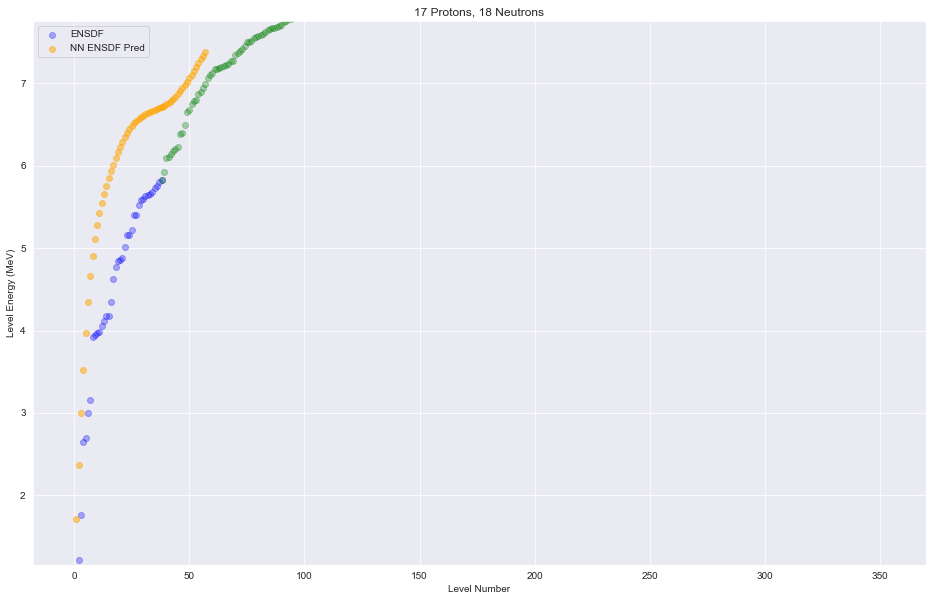

XS Tree vs EXFOR:
The MSE is:  1.5702587130270047
The R2-Score is:  0.1469713167639073


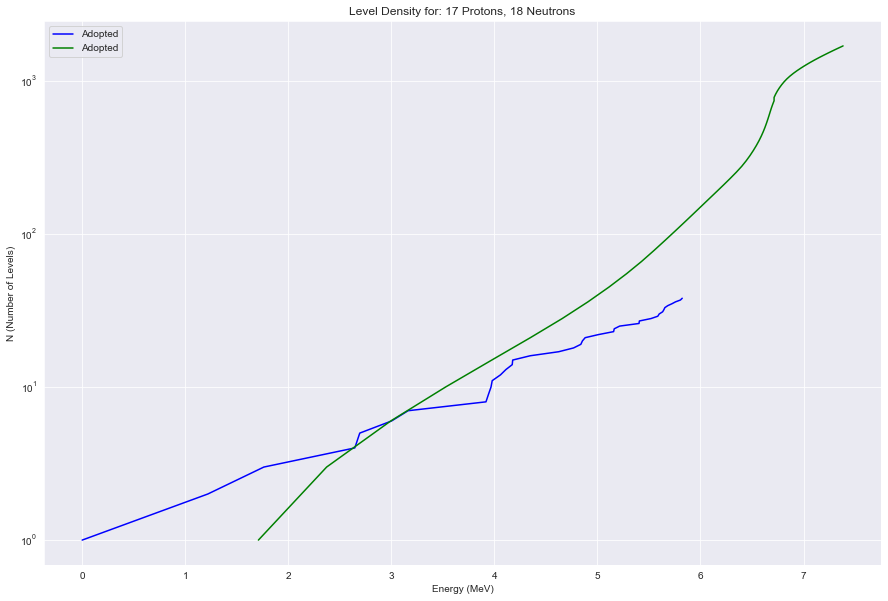

In [239]:
predicting_nuclear_xs(17, 35-17, regularizer_histories['l2_2000'].model, N=20, adopted=True, tf_dataset=True)

# Neural Networks

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

If the model is not complex enough and its left training for emore than necessary the accuracy of the model stagnates or start decreasing. This is a sympton of overfitting. Overfit often translates to higher accuracies on the training dataset but does not generalize well to a testing set. The opposite is underfiting (not trained for long enough or the model is not complex enough) meaning model not powerful enough or over regularized. 

The network needs to learn relevant patters in the data. If training for too long it learns the weights to memorize and not model the data. We need to strike a balance between both. How many epochs do we train for? How much regularization?

Prevent overfitting by:
- More complete training data (dataset must cover full range of inputs that it is expected to handle).
- Additional data is needed to cover other cases
- If no more data gathering is possible we need to use regularization
- Regularization places constraints on the quantity and type of information your model can store.

At the end is all about learnable parameters which is determined by the # of layers and the units per layer. The number of learnable parameters is referred to as the models capacity. It is apparent that we can increase the models capacity to a point that it learns a perfect dictionary-like-mapping between datapoints and their targets but with no generalization power (useless on unseen data). 

If model is not complex enough it will learn compresssed representations which is not able to generalize well. There is a balance between too much and not much capacity. There is no methodology or formula to determine arquitecture size. We start with very few layers and parameteres and slowly increase the size of layers until we see diminishing validation loss

The strategy.scope() indicates part of the code to run distributed, creating model inside scope allows us to create mirrored vairables, compiling under the scope tells TF our intend to train model using this strategy.

In [33]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Optimization - Learning Rate

A gradually reducing learning rate with time performes better (jumping around). The `schedules.InverseTimeDecay` decreases rate hyperbolicallly to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 and so on.

# Compile and Fit Funciton - TensorBoard Logs

In [43]:
def get_optimizer(lr_schedule):
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200), # val_loss
        tf.keras.callbacks.TensorBoard(logdir/name)]

def compile_and_fit(model, name, train_dataset, test_dataset, STEPS_PER_EPOCH, BATCH_SIZE=None, 
                    optimizer=None, max_epochs=10000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=STEPS_PER_EPOCH*1000,
        decay_rate=1, staircase=False)
    
    if optimizer is None:
        optimizer = get_optimizer(lr_schedule)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae', 'mse'])
    model.summary()
    history = model.fit(
        train_dataset,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=test_dataset,
        callbacks=get_callbacks(name),
        verbose=0)        
    return history

In [36]:
cpu_strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")
single_gpu_strategy =  tf.distribute.OneDeviceStrategy(device="/GPU:0")
gpu_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(gpu_strategy.num_replicas_in_sync))

Number of devices: 2


# Create a tf.data.Dataset Generator

The larger the `BATCH_SIZE`, the more efficient TensorFlow operates. 

In [37]:
N_VALIDATION = len(x_test)
N_TRAIN = len(x_train)
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 500
FEATURES = len(x_train.columns)

In [38]:
def tf_dataset_gen(x, y, xt, yt, BUFFER_SIZE, BATCH_SIZE, gpu=False, multiplier=0, cache=False):
    if gpu == True:
        BATCH_SIZE = BATCH_SIZE * multiplier
        print("GPU: ON")
    train_dataset = tf.data.Dataset.from_tensor_slices((x.values, y.values)).shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((xt.values, yt.values)).batch(BATCH_SIZE)
    if cache == True: # Ensures loader doesnt re-read data at each epoch.
        train_dataset = train_dataset.cache()
        test_dataset = test_dataset.cache()
    STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
    print("BATCH SIZE: ", BATCH_SIZE)
    print("STEPS PER EPOCH: ", STEPS_PER_EPOCH)
    return train_dataset, test_dataset, STEPS_PER_EPOCH, BATCH_SIZE

In [39]:
train_dataset, test_dataset, STEPS_PER_EPOCH_CPU, BATCH_SIZE_CPU = tf_dataset_gen(
    x_train, y_train, x_test, y_test, BUFFER_SIZE, BATCH_SIZE)

BATCH SIZE:  500
STEPS PER EPOCH:  34


In [40]:
train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, BATCH_SIZE_GPU = tf_dataset_gen(
    x_train, y_train, x_test, y_test, BUFFER_SIZE, 5000, gpu=True, multiplier=2)

GPU: ON
BATCH SIZE:  10000
STEPS PER EPOCH:  1


# Training Models

In [41]:
size_histories = {}
size_histories_gpu = {}

In [56]:
%%time
with cpu_strategy.scope():
    tiny_model = tf.keras.Sequential([
        layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(1)])
    size_histories['Tiny_CPU'] = compile_and_fit(tiny_model, 'sizes/Tiny_CPU', train_dataset, 
                                                 test_dataset, STEPS_PER_EPOCH_CPU, max_epochs=5000)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:8.4583,  mae:2.1152,  mse:8.4583,  val_loss:7.6328,  val_mae:2.0460,  val_mse:7.5436,  
....................................................................................................
Epoch: 100, loss:1.5008,  mae:0.8879,  mse:1.5008,  val_loss:1.4844,  val_mae:0.8866,  val_mse:1.4640,  
....................................................................................................
Epoch: 200, loss:1.2620,  mae:0.8321,  mse:1.2620,  val_loss:1.2337,  val_mae:0.8344,  val_mse:1.2231,  
....

....................................................................................................
Epoch: 3700, loss:0.9527,  mae:0.7494,  mse:0.9527,  val_loss:0.9609,  val_mae:0.7596,  val_mse:0.9599,  
....................................................................................................
Epoch: 3800, loss:0.9285,  mae:0.7460,  mse:0.9285,  val_loss:0.9592,  val_mae:0.7604,  val_mse:0.9581,  
....................................................................................................
Epoch: 3900, loss:0.9450,  mae:0.7479,  mse:0.9450,  val_loss:0.9589,  val_mae:0.7601,  val_mse:0.9578,  
....................................................................................................
Epoch: 4000, loss:0.9568,  mae:0.7526,  mse:0.9568,  val_loss:0.9589,  val_mae:0.7616,  val_mse:0.9579,  
....................................................................................................
Epoch: 4100, loss:0.9463,  mae:0.7480,  mse:0.9463,  val_loss:0.9571,  

In [57]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10

Epoch: 0, loss:11.8482,  mae:2.4090,  mse:11.8482,  val_loss:5.7708,  val_mae:2.3991,  val_mse:11.5415,  
.....................................................................................

....................................................................................................
Epoch: 3500, loss:1.6454,  mae:0.9166,  mse:1.6454,  val_loss:0.7857,  val_mae:0.9045,  val_mse:1.5713,  
....................................................................................................
Epoch: 3600, loss:1.6433,  mae:0.9078,  mse:1.6433,  val_loss:0.7831,  val_mae:0.9039,  val_mse:1.5661,  
....................................................................................................
Epoch: 3700, loss:1.7160,  mae:0.9143,  mse:1.7160,  val_loss:0.7805,  val_mae:0.9033,  val_mse:1.5610,  
....................................................................................................
Epoch: 3800, loss:1.6555,  mae:0.9098,  mse:1.6555,  val_loss:0.7779,  val_mae:0.9026,  val_mse:1.5559,  
....................................................................................................
Epoch: 3900, loss:1.5788,  mae:0.9005,  mse:1.5788,  val_loss:0.7754,  

Text(0, 0.5, 'MSE [XS^2]')

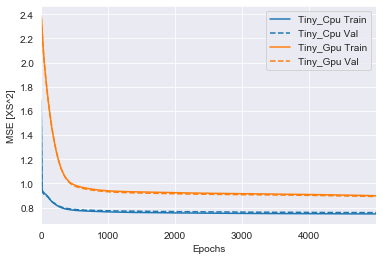

In [58]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mae', smoothing_std=5)
plotter.plot(size_histories)
plt.ylim()
plt.ylabel('MSE [XS^2]')

In [63]:
binning = []
binning.extend(np.arange(0,14,0.2))

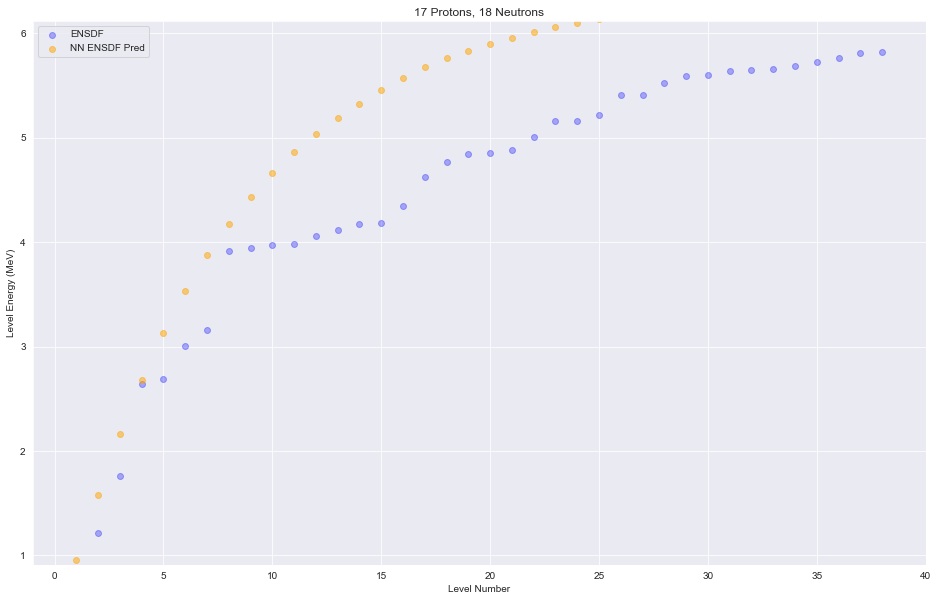

XS Tree vs EXFOR:
The MSE is:  0.6432732730654507
The R2-Score is:  0.6505476782063517


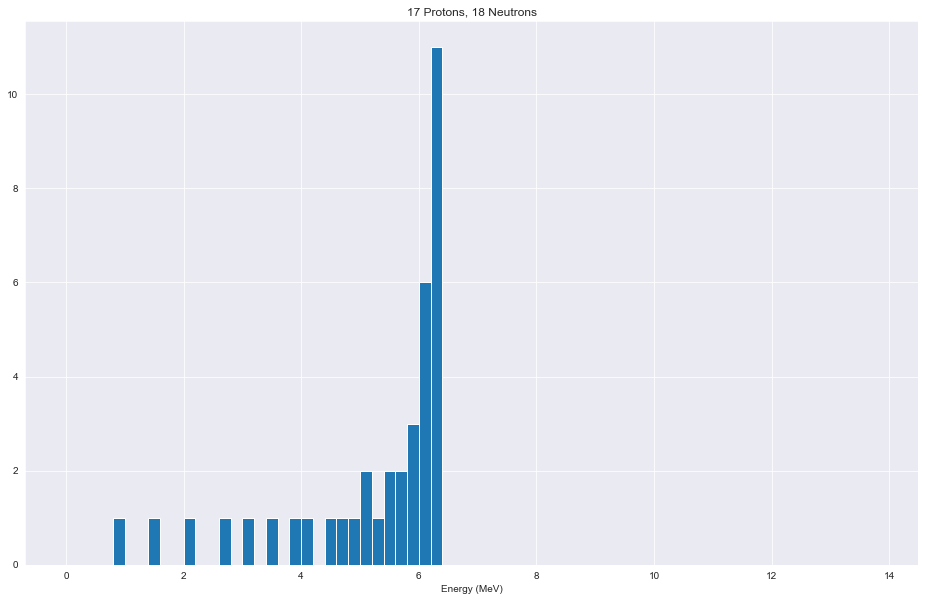

In [64]:
predicting_nuclear_xs(17, 35-17, size_histories['Tiny_CPU'].model, tf_dataset=True)

In [65]:
%%time
with gpu_strategy.scope():
    medium_model = tf.keras.Sequential([
        layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(64, activation='elu'),
        layers.Dense(64, activation='elu'),
        layers.Dense(1)])
    size_histories['Medium_GPU'] = compile_and_fit(medium_model, 'sizes/Medium_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, nu

....................................................................................................
Epoch: 3400, loss:0.8232,  mae:0.7007,  mse:0.8232,  val_loss:0.4195,  val_mae:0.7107,  val_mse:0.8390,  
....................................................................................................
Epoch: 3500, loss:0.8131,  mae:0.6956,  mse:0.8131,  val_loss:0.4180,  val_mae:0.7078,  val_mse:0.8359,  
....................................................................................................
Epoch: 3600, loss:0.8088,  mae:0.6939,  mse:0.8088,  val_loss:0.4154,  val_mae:0.7067,  val_mse:0.8309,  
....................................................................................................
Epoch: 3700, loss:0.8285,  mae:0.6995,  mse:0.8285,  val_loss:0.4135,  val_mae:0.7041,  val_mse:0.8270,  
....................................................................................................
Epoch: 3800, loss:0.8287,  mae:0.6994,  mse:0.8287,  val_loss:0.4127,  

In [67]:
%%time
with gpu_strategy.scope():
    large_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(1)])
    size_histories['Large_GPU'] = compile_and_fit(large_model, 'sizes/Large_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=50000)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:8.4581,  mae:2.0742,  mse:8.4581,  val_loss:4.1595,  val_mae:2.3012,  val_mse:8.3191,  
..........

....................................................................................................
Epoch: 3500, loss:0.5376,  mae:0.5610,  mse:0.5376,  val_loss:0.2810,  val_mae:0.5681,  val_mse:0.5621,  
....................................................................................................
Epoch: 3600, loss:0.5535,  mae:0.5734,  mse:0.5535,  val_loss:0.2800,  val_mae:0.5671,  val_mse:0.5599,  
....................................................................................................
Epoch: 3700, loss:0.5431,  mae:0.5650,  mse:0.5431,  val_loss:0.2765,  val_mae:0.5652,  val_mse:0.5530,  
....................................................................................................
Epoch: 3800, loss:0.5323,  mae:0.5606,  mse:0.5323,  val_loss:0.2842,  val_mae:0.5766,  val_mse:0.5683,  
....................................................................................................
Epoch: 3900, loss:0.5770,  mae:0.5724,  mse:0.5770,  val_loss:0.2840,  

Text(0.5, 0, 'Epochs [Log Scale]')

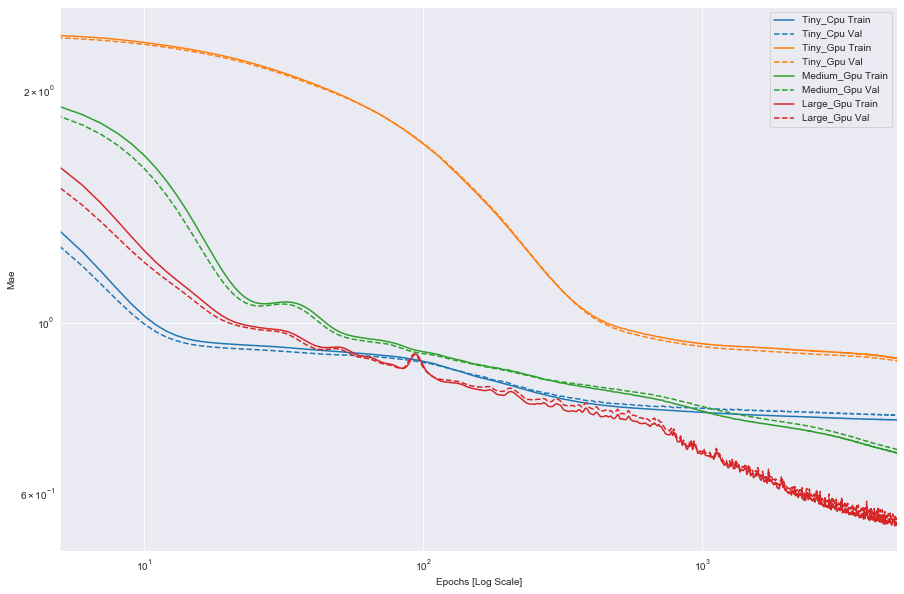

In [68]:
plt.figure(figsize=(15,10))
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
# plt.ylim([0.5, 0.7])
plt.yscale('log')
plt.xlabel("Epochs [Log Scale]")

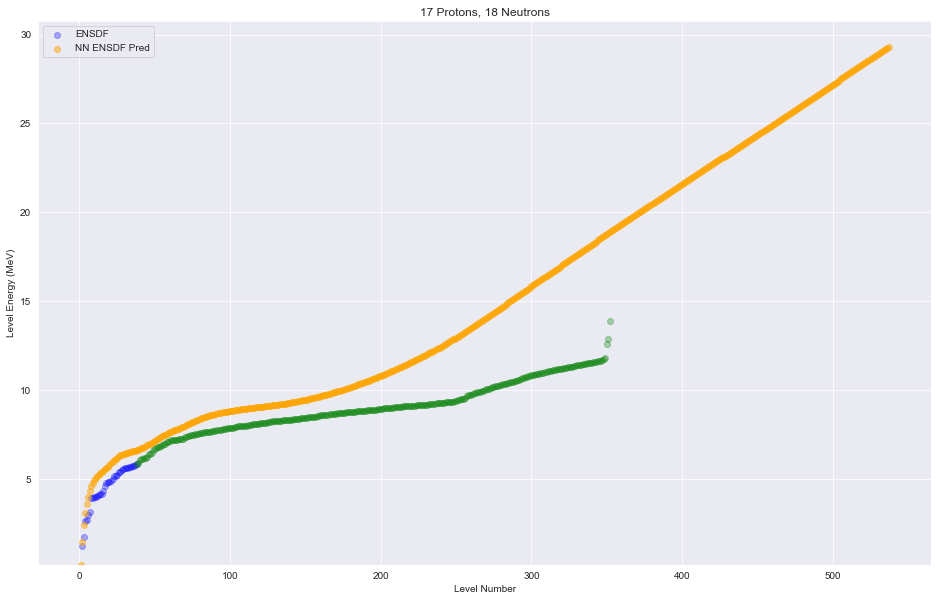

XS Tree vs EXFOR:
The MSE is:  0.8106378225823283
The R2-Score is:  0.5596284175072208
hello


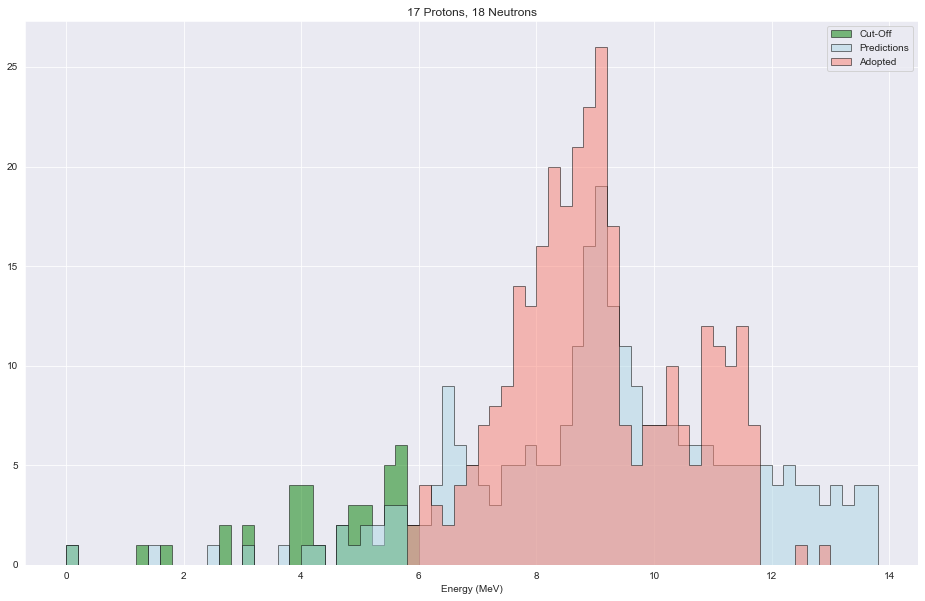

In [222]:
predicting_nuclear_xs(17, 35-17, size_histories['Large_GPU'].model, N=500, adopted=True, tf_dataset=True)

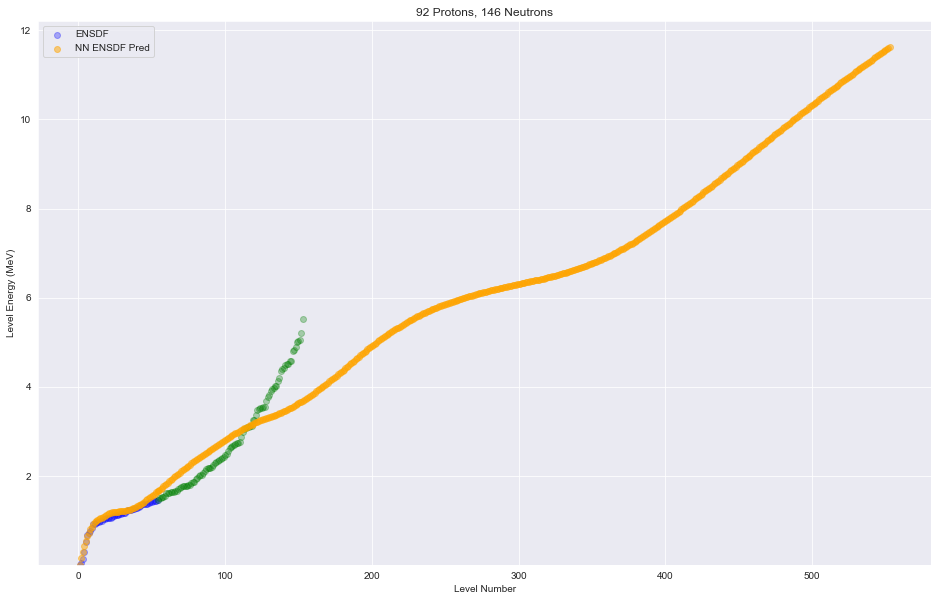

XS Tree vs EXFOR:
The MSE is:  0.006604188796412236
The R2-Score is:  0.9429428153890171
hello


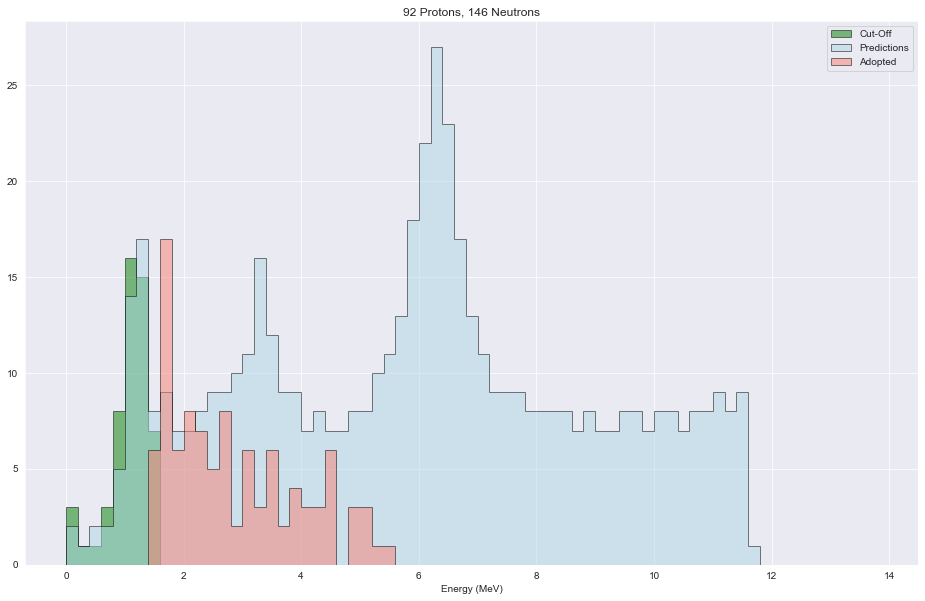

In [208]:
predicting_nuclear_xs(92, 238-92, size_histories['Large_GPU'].model, N=500, adopted=True, tf_dataset=True)

# Adding Regularization

As we know from Occam's Razor Principle the simplest one is the most likeley to be correct (the one with least amount of assumptions). Similar for neural networks, there will always be multiple models and therefore weights that can explain data. A simple model in this context is a model where the distribution of parameter values has less entropy. A common way to mitigate overfitting is to put constraints on the complexity of the NN by forcing weights to take small values which makes the distribution of such values more regular (weight regularization). This can be done by adding to the loss functionof the network a cost associated with having large weights. This costs can be:
- L1 Regularization: cost added proportional to the absolute value of the weights coefficients (L1 Norm). It pushes weights towards exactly 0 encouraging sparsity.
- L2 Regularization: proportional to the square of the value of the weights coefficients (L2 Norm). It is also called weight decay in NN context. It penalizes weight parameters without making them sparse since the weights go to 0 but are not 0. More common of the two. 

The `regularizers.l2(VALUE)` will make that every coefficient in the weight matrix of the layer will add VALUE * $weight_coefficients_value**2$ to the total loss of the network. In binary classification problems we monitor binary crossentropy since it doesnt have this regularization component mixed in.

Check if l2 is better than large at overfitting (same parameters)?

Dropout one of the most effective and most commonly used for NN. It is based on the fact that individual nodes in the N cannot rely on the output of the otherse, each node must output features that are useful on their own. The drooput layer randomly droppes out (set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The dropout rate is the fraction of features that are zeroed out (between 0.2 to 0.5 usually). 

In [212]:
regularizer_histories = {}
regularizer_histories['Tiny_CPU'] = size_histories['Tiny_CPU']

In [213]:
%%time
with gpu_strategy.scope():
    l2_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])
    
    regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:10.6016,  mae:2.1318,  mse:9.0566,  val_loss:5.6952,  val_mae:2.3085,  val_mse:8.3010,  
.........

....................................................................................................
Epoch: 3500, loss:0.9879,  mae:0.6357,  mse:0.7084,  val_loss:0.6231,  val_mae:0.6338,  val_mse:0.6872,  
....................................................................................................
Epoch: 3600, loss:0.9748,  mae:0.6440,  mse:0.6988,  val_loss:0.6313,  val_mae:0.6413,  val_mse:0.7107,  
....................................................................................................
Epoch: 3700, loss:0.9387,  mae:0.6246,  mse:0.6662,  val_loss:0.6140,  val_mae:0.6333,  val_mse:0.6831,  
....................................................................................................
Epoch: 3800, loss:0.9511,  mae:0.6290,  mse:0.6818,  val_loss:0.6130,  val_mae:0.6407,  val_mse:0.6874,  
....................................................................................................
Epoch: 3900, loss:0.9219,  mae:0.6233,  mse:0.6552,  val_loss:0.6068,  

In [223]:
%%time
with gpu_strategy.scope():
    l2_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])
    
    regularizer_histories['l2_2000'] = compile_and_fit(l2_model, 'regularizers/l2_2000', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=20000)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_47 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_48 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_49 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:10.9240,  mae:2.1571,  mse:9.3798,  val_loss:5.5845,  val_mae:2.2883,  val_mse:8.0816,  
........

....................................................................................................
Epoch: 3500, loss:0.9508,  mae:0.6325,  mse:0.6782,  val_loss:0.6215,  val_mae:0.6398,  val_mse:0.6981,  
....................................................................................................
Epoch: 3600, loss:0.9604,  mae:0.6368,  mse:0.6910,  val_loss:0.6158,  val_mae:0.6325,  val_mse:0.6928,  
....................................................................................................
Epoch: 3700, loss:0.9423,  mae:0.6314,  mse:0.6760,  val_loss:0.6109,  val_mae:0.6330,  val_mse:0.6893,  
....................................................................................................
Epoch: 3800, loss:0.9413,  mae:0.6243,  mse:0.6781,  val_loss:0.6118,  val_mae:0.6371,  val_mse:0.6973,  
....................................................................................................
Epoch: 3900, loss:0.9356,  mae:0.6343,  mse:0.6752,  val_loss:0.6030,  

....................................................................................................
Epoch: 7500, loss:0.8225,  mae:0.5920,  mse:0.6005,  val_loss:0.5307,  val_mae:0.5953,  val_mse:0.6174,  
....................................................................................................
Epoch: 7600, loss:0.8132,  mae:0.5871,  mse:0.5918,  val_loss:0.5259,  val_mae:0.5917,  val_mse:0.6090,  
....................................................................................................
Epoch: 7700, loss:0.8040,  mae:0.5828,  mse:0.5832,  val_loss:0.5253,  val_mae:0.5943,  val_mse:0.6090,  
....................................................................................................
Epoch: 7800, loss:0.8172,  mae:0.5915,  mse:0.5969,  val_loss:0.5230,  val_mae:0.5918,  val_mse:0.6055,  
....................................................................................................
Epoch: 7900, loss:0.8261,  mae:0.5943,  mse:0.6063,  val_loss:0.5283,  

....................................................................................................
Epoch: 11500, loss:0.7583,  mae:0.5700,  mse:0.5547,  val_loss:0.4952,  val_mae:0.5807,  val_mse:0.5832,  
....................................................................................................
Epoch: 11600, loss:0.7766,  mae:0.5771,  mse:0.5733,  val_loss:0.4973,  val_mae:0.5830,  val_mse:0.5880,  
....................................................................................................
Epoch: 11700, loss:0.7703,  mae:0.5769,  mse:0.5673,  val_loss:0.4971,  val_mae:0.5846,  val_mse:0.5882,  
....................................................................................................
Epoch: 11800, loss:0.7712,  mae:0.5740,  mse:0.5685,  val_loss:0.4938,  val_mae:0.5814,  val_mse:0.5822,  
....................................................................................................
Epoch: 11900, loss:0.7807,  mae:0.5840,  mse:0.5784,  val_loss:0.49

In [215]:
%%time
with gpu_strategy.scope():
    dropout_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)             

....................................................................................................
Epoch: 3200, loss:0.9576,  mae:0.7555,  mse:0.9576,  val_loss:0.4182,  val_mae:0.7245,  val_mse:0.8364,  
....................................................................................................
Epoch: 3300, loss:0.9601,  mae:0.7608,  mse:0.9601,  val_loss:0.4138,  val_mae:0.7217,  val_mse:0.8276,  
....................................................................................................
Epoch: 3400, loss:0.9352,  mae:0.7450,  mse:0.9352,  val_loss:0.4088,  val_mae:0.7186,  val_mse:0.8175,  
....................................................................................................
Epoch: 3500, loss:0.9638,  mae:0.7569,  mse:0.9638,  val_loss:0.4025,  val_mae:0.7138,  val_mse:0.8050,  
....................................................................................................
Epoch: 3600, loss:0.9097,  mae:0.7371,  mse:0.9097,  val_loss:0.4028,  

In [216]:
%%time
with gpu_strategy.scope():
    combined_model = tf.keras.Sequential([
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['combined'] = compile_and_fit(combined_model, 'regularizers/combined', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 512)               2560      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)             

....................................................................................................
Epoch: 3200, loss:1.0917,  mae:0.7732,  mse:1.0035,  val_loss:0.5467,  val_mae:0.7565,  val_mse:0.9169,  
....................................................................................................
Epoch: 3300, loss:1.0936,  mae:0.7662,  mse:1.0064,  val_loss:0.5413,  val_mae:0.7523,  val_mse:0.9083,  
....................................................................................................
Epoch: 3400, loss:1.0628,  mae:0.7660,  mse:0.9767,  val_loss:0.5387,  val_mae:0.7523,  val_mse:0.9051,  
....................................................................................................
Epoch: 3500, loss:1.0553,  mae:0.7594,  mse:0.9700,  val_loss:0.5364,  val_mae:0.7518,  val_mse:0.9022,  
....................................................................................................
Epoch: 3600, loss:1.0628,  mae:0.7617,  mse:0.9783,  val_loss:0.5327,  

Text(0.5, 0, 'Epochs [Log Scale]')

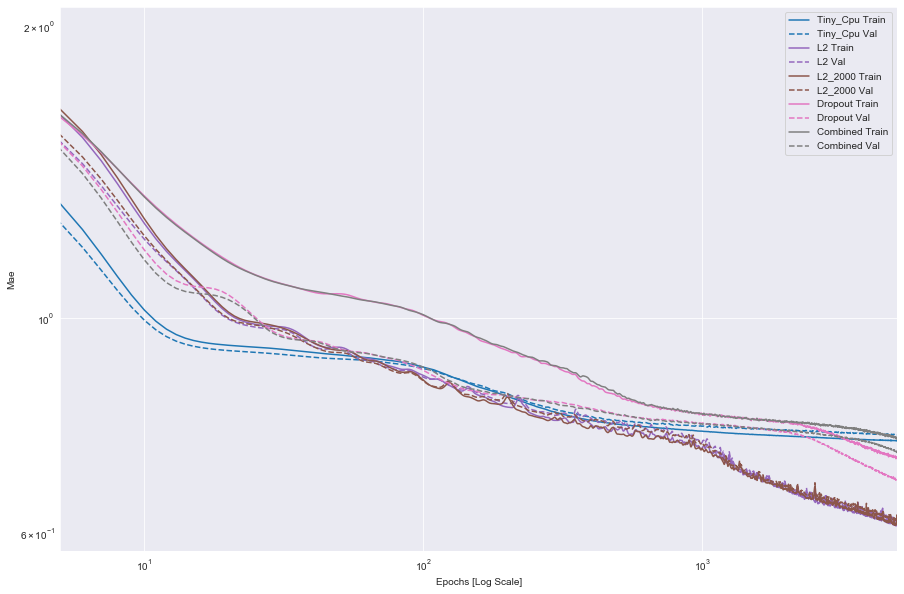

In [217]:
plt.figure(figsize=(15,10))
plotter.plot(regularizer_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
# plt.ylim([0.5, 0.7])
plt.yscale('log')
plt.xlabel("Epochs [Log Scale]")

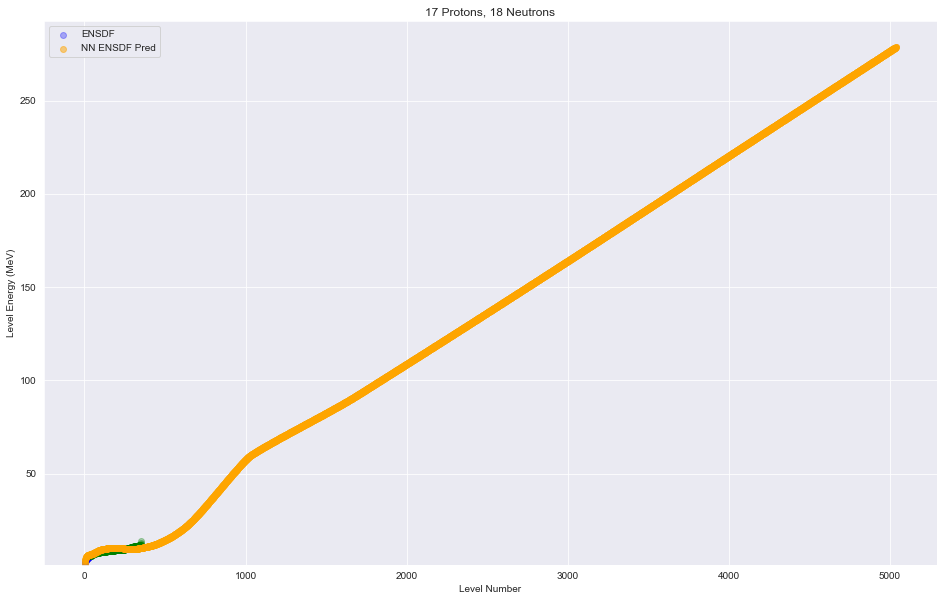

XS Tree vs EXFOR:
The MSE is:  1.5702596757168772
The R2-Score is:  0.1469707937914395
hello


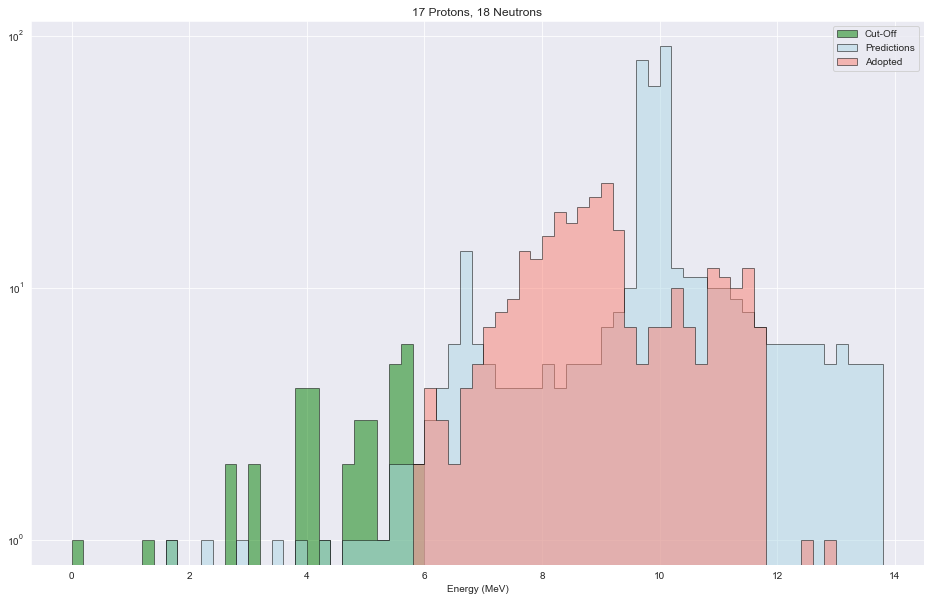

In [230]:
predicting_nuclear_xs(17, 35-17, regularizer_histories['l2_2000'].model, N=5000, adopted=True, tf_dataset=True)

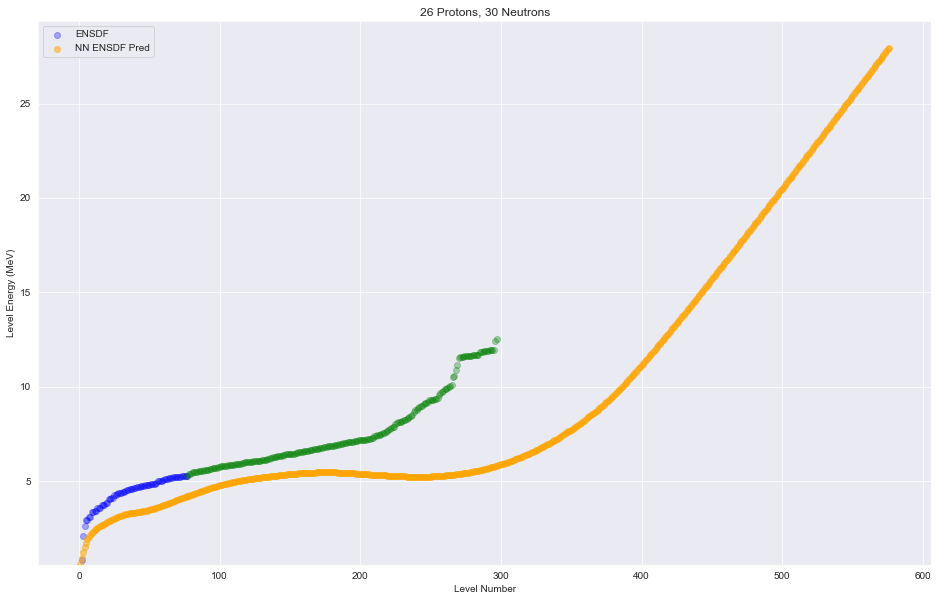

XS Tree vs EXFOR:
The MSE is:  1.4564214544633294
The R2-Score is:  -0.5548856812726191
hello


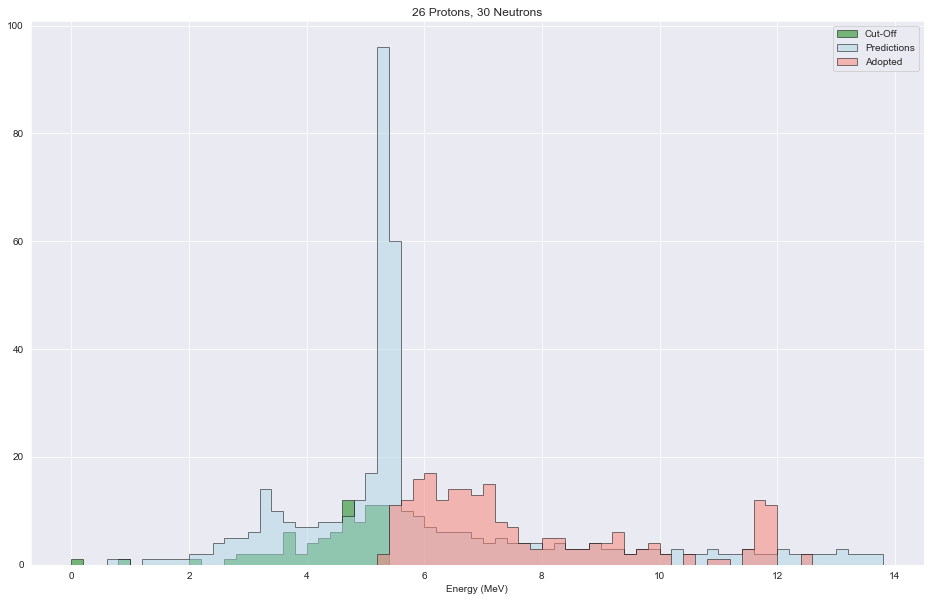

In [221]:
predicting_nuclear_xs(26, 56-26, regularizer_histories['l2_2000'].model, N=500, adopted=True, tf_dataset=True)

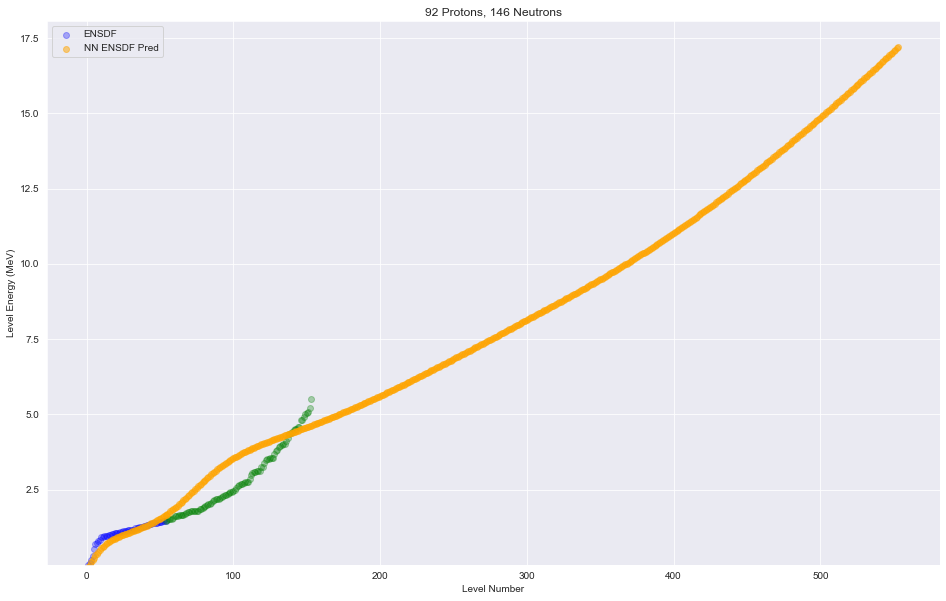

XS Tree vs EXFOR:
The MSE is:  0.030730315487489474
The R2-Score is:  0.7345040643180933
hello


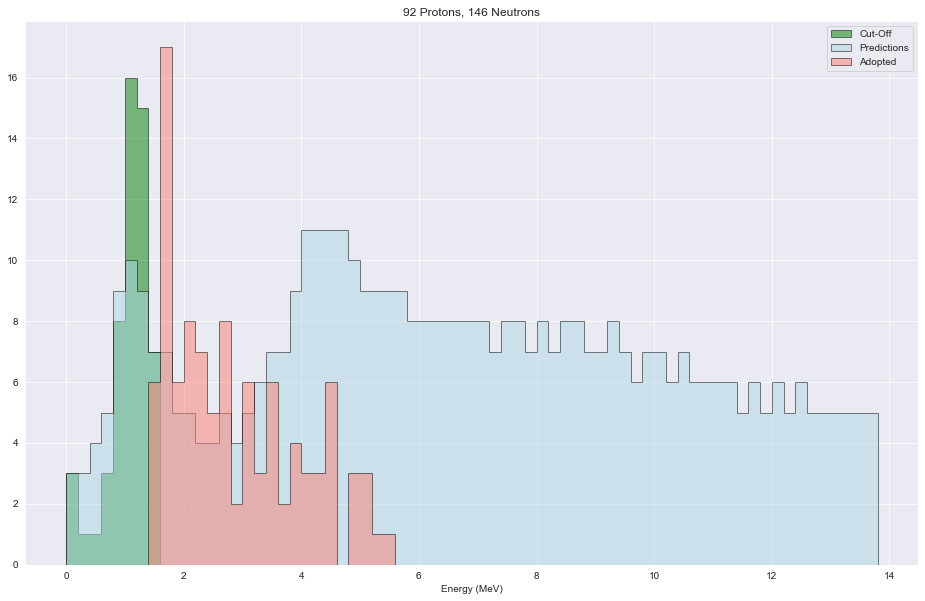

In [219]:
predicting_nuclear_xs(92, 238-92, regularizer_histories['l2_2000'].model, N=500, adopted=True, tf_dataset=True)

In [290]:
hist = pd.DataFrame(regularizer_histories['l2'].history)
hist['epoch'] = regularizer_histories['l2'].epoch
hist.tail()

loss       mae       mse  val_loss   val_mae   val_mse  epoch
295  3.423054  1.001607  2.655203  2.700178  0.975487  2.573845    295
296  3.360027  1.001824  2.592768  2.696059  0.989105  2.569116    296
297  3.418146  1.010282  2.651459  2.675017  0.977214  2.541878    297
298  3.681805  1.067090  2.915823  2.717230  0.984647  2.599586    298
299  3.674703  1.070685  2.909691  2.951144  1.073622  2.913288    299

In [75]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "./Checkpoints/L2/L2/"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [76]:
regularizer_histories['l2'].model.save_weights(checkpoint_dir)

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.